In [1]:
import torch
import torchvision

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt
import numpy as np

from __future__ import print_function, division
import os
from PIL import Image
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import collections
from collections import OrderedDict
import torch.nn.init as init

import datetime                      # to include date in log file name

import sobol_seq

# the following command line produces sound and is used after cells that 
# require more time to execute :
import IPython.display # to display .png

from IPython.display import Audio
wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 

In [2]:
random_seed= 2019
batch_size = 8
validation_split = .10
shuffle_dataset = True
num_workers = 0        # dataloader issues with numworkers > 0

# used to scale tensor from [0 to 1] to [0 to 255]
def multby255 (pic) :
    return pic.mul(255)

# setting up data loader
root = './data_catdogs/trainset/'

# different ways to augment the data
data_transforms = {
    'veryaugmented': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomResizedCrop(74, scale=(0.85, 1.0), ratio=(0.85, 1.15), interpolation=2),
        transforms.RandomResizedCrop(80, scale=(0.85, 1.0), ratio=(0.8, 1.2), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'augmented': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'normal': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ])
}

# to be able to train and valide on both the original and the augmented dataset
train_dataset_augm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["veryaugmented"])
train_dataset_norm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["normal"])

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset_augm)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# 
batch_size = 32
train_norm_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
train_augm_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_norm_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
valid_augm_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

compute size

In [3]:
dummy_train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=1, sampler=train_sampler, num_workers=0)
dummy_valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=1, sampler=valid_sampler, num_workers=0)
train_dataset_size  = dummy_train_loader.__len__()
valid_dataset_size   = dummy_valid_loader.__len__()
print("training   dataset size : " , train_dataset_size)
print("validation dataset size : " , valid_dataset_size)
del dummy_train_loader 
del dummy_valid_loader 

training   dataset size :  17999
validation dataset size :  1999


Setting the directory of the pictures

Display some samples

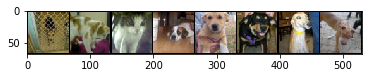

    1     0     0     1     1     1     1     1
torch.Size([3, 64, 64])


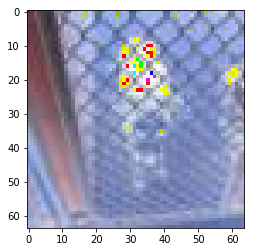

tensor(211.)


In [4]:
batch_size = 8
# picture_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
pict_n_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

sz = 64
tosmaller = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(sz, interpolation=2),
                transforms.ToTensor(),
                transforms.Lambda(multby255)
            ])

# functions to show an image

def imshow(img):
    npimg = img.numpy() / 255
    # npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(pict_n_loader) :
    if i > 0 : break

    # show images
    imshow(torchvision.utils.make_grid(images ))
    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(min(batch_size,8))))
    sample_image = images[0]

print(sample_image.shape)
imshow(torchvision.utils.make_grid( tosmaller(sample_image) ))
print( torch.max(sample_image) )

set the device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## The model 
architecture taken from : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [6]:
class MLP(nn.Module):
    def __init__(self, h1, h2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*64*64, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 1)

    def forward(self, x):
        x = x.view( -1, 3*64*64 )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz = 3 ):
        
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.fct = nn.Linear(4*4*128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4*4*128)
        x = torch.sigmoid(self.fct(x))
        # x = self.fct(x)
        # x = F.softmax(self.fct(x),dim=-1)
        return x

In [8]:
class Classifier1(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1 = 9, kernel_sz2 = 3 ):
        
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0:
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2 
        
        super(Classifier1, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, feature map size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, feature map size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz1 , kernel_sz1), padding=pad1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, feature map size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz1 , kernel_sz1), padding=pad1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4, feature map size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, feature map size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
        )
        # 
        self.fct1 = nn.Linear(4*4*256, 1024)
        self.fct2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fct1(x)
        x = F.softmax(self.fct2(x),dim=-1)
        return x

In [9]:
class Classifier1b(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1=13 , kernel_sz2=11, regression = 800, sigmoid=False ):
        
        self.sigmoid = sigmoid
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2 
        
        super(Classifier1b, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1 ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer intermediaire, input size = 32^2, output size 14^2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=( 10 , 10), padding=2,  stride = 2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 14^2, output size 4^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( 3 , 3 ), padding = 0, stride = 3),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),     
        )
        
        # Regression
        self.clf1 = nn.Linear(4*4*64, regression)
        self.clf2 = nn.Linear(regression, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.clf1(x)
        x = self.clf2(x)
        return x

In [10]:
class Classifier1c(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1=9 , kernel_sz2=9, sigmoid=False ):
        
        self.sigmoid = sigmoid
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2
        
        stride1 = 1
        stride2 = 1
        
        super(Classifier1c, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1, stride=stride1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=( kernel_sz2 , kernel_sz2), padding=pad2, stride=stride2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 64^2, output size = 8^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( 37 , 37 ), padding=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 8^2, output size 2^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( 3 , 3 ), padding = 1, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)     
        )
        
        # Regression
        self.clf = nn.Linear(2*2*64, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.clf(x)
        return x

In [11]:
class Classifier2(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,9,7,3,3])
        pad = kernel_sz // 2 
        pad[4] = 0
        
        super(Classifier2, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(512, 512)
        self.fct2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

taken from :  
https://medium.com/@harsathAI/cats-and-dogs-classifier-convolutional-neural-network-with-python-and-tensorflow-9-steps-of-6259c92802f3

In [12]:
class Classifier3(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        # kernel_sz = np.array([3,3,3,3,3,3])
        pad = kernel_sz // 2 
        # pad[4] = 0
        
        super(Classifier3, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct = nn.Linear(8*8*256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,8*8*256)
        x = self.fct(x)
        return x

In [13]:
class Classifier4(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        pad = kernel_sz // 2 
        pad[5] = 0
        
        super(Classifier4, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(1*1*512, 512)
        self.fct2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

In [14]:
class Classifier5(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)           
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = self.fct1b(x)
        return x

In [15]:
class Classifier5b(nn.Module):
    """Convnet Classifier"""
    def __init__(self , sigmoid = True):
        
        self.sigmoid = sigmoid
        kernel_sz = np.array([11,9,7,5,3,3,3])
        pad = kernel_sz // 2 
        pad[6] = 0 
        
        super(Classifier5b, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 64^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 32^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5, input size = 16^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 8^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, input size = 4^2, output size = 1^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.fct1b(x)
        return x

In [16]:
class Classifier5c(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3])
        pad = kernel_sz // 2 
        
        super(Classifier5c, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, input size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 2^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # 
        self.fct1 = nn.Linear(1*1*256, 256)
        self.fct2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*256)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

In [17]:
class Classifier5d(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5d, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1b(x))
        x = F.softmax(x,dim=-1)
        return x

In [18]:
class Classifier6(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,7,3,3,3,3,3,2])
        pad = kernel_sz // 2 
        pad[8] = 0 
        
        super(Classifier6, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, feature map size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, feature map size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, feature map size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 4, feature map size = 16^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 5, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            
            # Layer 6, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, feature map size = 8^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 8, feature map size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[7], kernel_sz[7]) , padding=pad[7]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 9, feature map size = 2^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[8], kernel_sz[8]) , padding=pad[8])    
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = self.fct1b(x)
        return x

Print the number of parameters in each models and display the computation 

In [19]:
def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "number of params = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth
  

In [20]:
import torchvision.models # for vgg16

list_of_models = [ 
    torchvision.models.vgg16( pretrained=False, num_classes=2, init_weights=False ),
    MLP(620,620),
    Classifier(9),
    Classifier5(),
    Classifier5b()
]
for net in list_of_models:
    print( net.__doc__ )
    _ , _ = number_of_params( net , display_comp = True )

None
number of params =  134268738  =   
 (features.0.weight)      64*3*3*3
 (features.0.bias)      + 64
 (features.2.weight)    + 64*64*3*3
 (features.2.bias)      + 64
 (features.5.weight)    + 128*64*3*3
 (features.5.bias)      + 128
 (features.7.weight)    + 128*128*3*3
 (features.7.bias)      + 128
 (features.10.weight)   + 256*128*3*3
 (features.10.bias)     + 256
 (features.12.weight)   + 256*256*3*3
 (features.12.bias)     + 256
 (features.14.weight)   + 256*256*3*3
 (features.14.bias)     + 256
 (features.17.weight)   + 512*256*3*3
 (features.17.bias)     + 512
 (features.19.weight)   + 512*512*3*3
 (features.19.bias)     + 512
 (features.21.weight)   + 512*512*3*3
 (features.21.bias)     + 512
 (features.24.weight)   + 512*512*3*3
 (features.24.bias)     + 512
 (features.26.weight)   + 512*512*3*3
 (features.26.bias)     + 512
 (features.28.weight)   + 512*512*3*3
 (features.28.bias)     + 512
 (classifier.0.weight)  + 4096*25088
 (classifier.0.bias)    + 4096
 (classifier.3.

# Training  
training algorithm below

In [21]:
# make sound once done, should only be used to wrap a function that returns nothing 
def make_sound(func):
    def wrapper_make_sound(*args, **kwargs):
        func(*args, **kwargs)
        wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
        audio = Audio(wave, rate=10000, autoplay=True)
        return audio
    return wrapper_make_sound

# measure time with cuda events
def display_timer(func):
    def wrapper_display_timer(*args, **kwargs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        res = func(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        print( "Time required = " , start.elapsed_time(end)*0.001 , " s ")
        return res
    return wrapper_display_timer

@make_sound
@display_timer
def fake_training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, valid_loader, state_dict_list ):
    pass
    
@make_sound
@display_timer
def training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, valid_loader, state_dict_list ):

    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        running_loss  = torch.tensor([0], dtype=torch.float, device = device) 
        correct       = torch.tensor([0], device = device)
        total         = torch.tensor([0], device = device) 
        valid_acc     = torch.tensor([0], device = device)
        valid_loss    = torch.tensor([0], device = device)
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute the correctness of the output labels
            with torch.no_grad() :
                _, predicted = torch.max(outputs.data, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum()

            # print statistics
            running_loss += loss.item()
        else : # print every epoch
            avg_loss[epoch,0] = running_loss / total.float()
            accuracy[epoch,0] = 100 * correct.float() / total.float()
            
            valid_acc, valid_loss = measure_single_accuracy_and_loss(net, valid_loader, criterion )
            avg_loss[epoch,1] = valid_loss
            accuracy[epoch,1] = valid_acc
            
            print( 'epoch = %3d, train loss = %.6f , train accuracy = %3f , valid loss = %.6f , valid accuracy = %3f' 
                          % (epoch + 1, avg_loss[epoch,0], accuracy[epoch,0], avg_loss[epoch,1], accuracy[epoch,1] )
                 ) 
            # save the current model's state_dictionnary
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in net.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()         

    else : 
        print('Finished Training')

# measure accuracy of a single net, returns the accuracy
def measure_single_accuracy_and_loss( net, loader, criterion ):
    accuracy = 0.0
    avg_loss = 0.0
    with torch.no_grad():
        correct = torch.tensor([0], device=device)
        total   = torch.tensor([0], device=device)
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images).squeeze()
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum()
            avg_loss+= loss.item()
        accuracy = 100 * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
        avg_loss = avg_loss/total.type(torch.FloatTensor)
    return accuracy, loss        


### Plotting  
plotting function

In [52]:
# display 2 plots, accuracy and loss across epoch, their .shape must be n x 2, 
# want_log indicates that user wants to save the plot to a file
# filename should not contains the extension of the file
def plot_1d_acc_and_loss(net, accuracy, loss, path_to_save, filename, 
                         net_name="",want_log = False, figsize = (16,10), font_size = 16 ):
    
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
    
    nb_epoch =  accuracy.size()[0]
    
    x = np.linspace(1, nb_epoch, nb_epoch)
    
    y1a = copy.deepcopy(accuracy[:,1]).cpu().numpy()
    y1b = copy.deepcopy(accuracy[:,0]).cpu().numpy()
    line1a_label = "accuracy on the validation set"
    line1b_label = "accuracy on the training   set"
    
    y2a = copy.deepcopy(loss[:,1]).cpu().numpy()
    y2b = copy.deepcopy(loss[:,0]).cpu().numpy()
    line2a_label = "avg loss on the validation set"
    line2b_label = "avg loss on the training   set"
    
    plt.subplot(2,1,1)

    plt.axhline(y=75,color="black")

    line1a, = plt.plot(x, y1a, "o-", label=line1a_label)
    line1a.set_dashes([2, 2])  # 2pt line, 2pt break

    line1b, = plt.plot(x, y1b, "x-", label=line1b_label)
    line1b.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title1 = "Accuracy during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2,1,2)
    
    line2a, = plt.plot(x, y2a, "o-", label=line2a_label)
    line2a.set_dashes([2, 2])  # 2pt line, 2pt break

    line2b, = plt.plot(x, y2b, "x-", label=line2b_label)
    line2b.set_dashes([2, 2])  # 2pt line, 2pt break
    
    str_title1 = "Loss during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if net_name != "" :
        plt.suptitle(net_name, fontsize=font_size)
    
    want_log     = False
    path_to_save = "./output/" 
    filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
    if want_log :
        plt.savefig(path_to_save + filename + ".png")
        with open(path_to_save + filename + ".txt",'w+') as f:
            nb_params, depth = number_of_params(net)
            line = "{name} : number of parameters = {n}, depth = {d}. , lr = {lr}, batch size = {bs}".format(name = net.__doc__, n = nb_params, d=depth, lr=lr, bs = bs)
            f.write(line)
    plt.show()

init method

In [28]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)

In [29]:
net1 = Classifier5()
net1.apply( glorot_init )  
_ = net1.to(device)

In [30]:
# define the loss function as the cross entropy and choose a learning rate that works well
criterion = nn.CrossEntropyLoss()
lr = 0.0005
optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.0, weight_decay=0)
nb_epoch  = 2

train_batch_size = 1*32
valid_batch_size = 16*64
train_loader = DataLoader(train_dataset_augm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
net1_state_dict_list = list()        # we save (all) the intermediate state of the model during the learning phase

# accuracy and average loss across epoch, 0 (resp. 1) correspond to the training (reps. validation)
avg_loss1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
accuracy1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)

In [33]:
training_phase( net1, nb_epoch, criterion, optimizer, avg_loss1, accuracy1, train_loader, valid_loader, net1_state_dict_list )

epoch =   1, train loss = 0.078280 , train accuracy = 65.175842 , valid loss = 0.992223 , valid accuracy = 62.881439
epoch =   2, train loss = 0.074871 , train accuracy = 68.309349 , valid loss = 0.415305 , valid accuracy = 69.734871
Finished Training
Time required =  161.4245625  s 


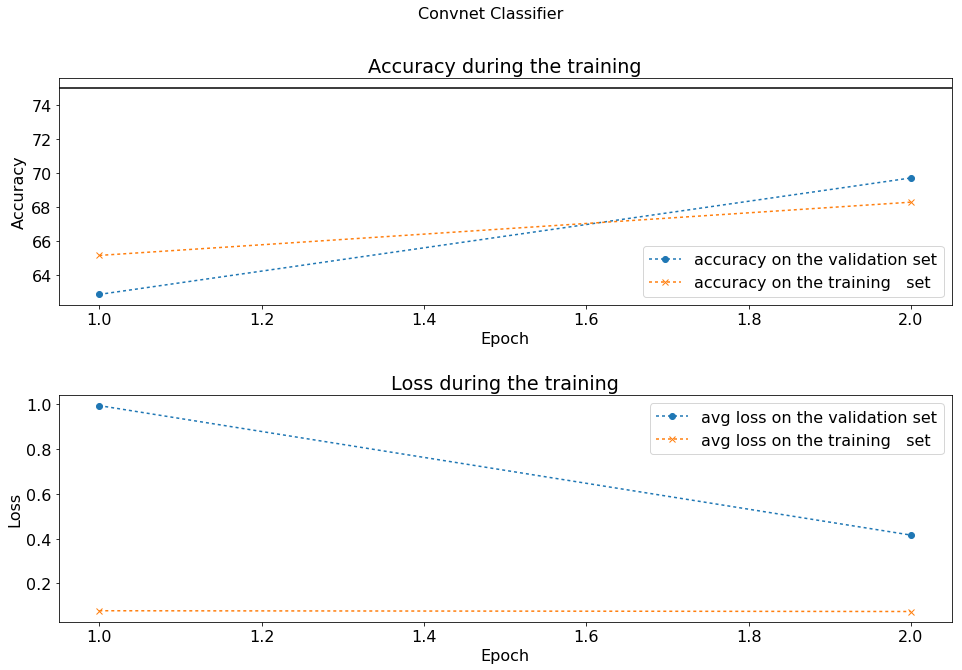

In [53]:
path_to_save = ""
filename     = ""

plot_1d_acc_and_loss(net1, accuracy1, avg_loss1, path_to_save, filename, net1.__doc__ )

In [78]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cudanet.parameters(), lr=0.00075, momentum=0, weight_decay=0)
want_to_test = False
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # if using BCE
            # labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cudanet(inputs)
            loss = criterion(outputs, labels)
            
            print( outputs.size() , labels.size() )
            print( loss )

            break

torch.Size([16, 2]) torch.Size([16])
tensor(7.7164, device='cuda:0')


### Find a good initialization  
Try different random init, train them for 3 epoch, repeat until you find one than has learnt something

In [30]:
# del cudanet 
nb_epoch  = 1
nb_try    = 3
batch_size = 1*16
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for trial in range(nb_try) :
    cudanet = Classifier5()
    # cudanet = Classifier1b(sigmoid=True)
    cudanet.apply( glorot_init )
    _ = cudanet.to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(cudanet.parameters(), lr=0.00025, momentum=0, weight_decay=0)
    optimizer = optim.SGD(cudanet.parameters(), lr=0.0001, momentum=0, weight_decay=0)
    correct = torch.tensor([0])
    total = torch.tensor([0])
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times 

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # if using BCE :
            # labels = labels.float() 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cudanet(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            with torch.no_grad() :
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        else : # print every epoch
            print('trial %d , epoch = %d, loss = %.8f' % (trial + 1, epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
            running_loss = 0.0
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in cudanet.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()
    accuracy = 100*correct.double()/total.double()
    print("Accuracy for trial %d : %.4f %%" % (trial+1 , accuracy) )
    if accuracy > 53 :
        print('Successful search')
        break
    del cudanet
else : 
    print('Unsuccessful search')
    
end.record()
torch.cuda.synchronize()

print( "time required = " , start.elapsed_time(end)*0.001 , " s ")
Audio(wave, rate=10000, autoplay=True)

trial 1 , epoch = 1, loss = 0.04490612
Accuracy for trial 1 : 60.0663 %
Successful search
time required =  30.71540234375  s 


NameError: name 'wave' is not defined

## Training the model  

Note : what seems to work best   
start with a good initialization (find one, save it, and load it instead of random init each time)  
(or 0.00075)  
begin with  : lr=0.0005   , batch_sz between 16 and 32  
change   to : lr=0.00005  , batch_sz between 32 and 4*32  

batch_sz >~ 2 * 64 , absolutely no learning

In [205]:
_ = cudanet.to(device)

In [32]:
use_BCE = False
if use_BCE :
    criterion = nn.BCELoss() # Binary Cross Entropy 
else :
    criterion = nn.CrossEntropyLoss() # Cross Entropy 

lr = 0.0001
optimizer = optim.SGD(cudanet.parameters(), lr=lr, momentum=0, weight_decay=0)
nb_epoch  = 30

In [33]:
batch_size = 1*16

# train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
train_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for epoch in range( nb_epoch ):  # loop over the dataset multiple times 
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        # is using CE, squeeze does nothing :
        outputs = cudanet(inputs).squeeze()
        
        # if i == 0 : print( outputs )
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    else : # print every epoch
        print('epoch = %d, loss = %.8f' % (epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
        running_loss = 0.0
        torch.cuda.synchronize()
        tmp_state_dict = {}
        for k, v in cudanet.state_dict().items():
            tmp_state_dict[k] = v.cpu()
        state_dict_list.append( tmp_state_dict )
        torch.cuda.synchronize()
        
else : 
    print('Finished Training')
    
end.record()
torch.cuda.synchronize()
print( "time required = " , start.elapsed_time(end)*0.001 , " s ")
Audio(wave, rate=10000, autoplay=True)

epoch = 1, loss = 0.03901073
epoch = 2, loss = 0.03776718
epoch = 3, loss = 0.03680312
epoch = 4, loss = 0.03620383
epoch = 5, loss = 0.03534397
epoch = 6, loss = 0.03488259
epoch = 7, loss = 0.03444808
epoch = 8, loss = 0.03395281
epoch = 9, loss = 0.03336197
epoch = 10, loss = 0.03301885
epoch = 11, loss = 0.03279720
epoch = 12, loss = 0.03221270
epoch = 13, loss = 0.03182727
epoch = 14, loss = 0.03147039
epoch = 15, loss = 0.03126159
epoch = 16, loss = 0.03092431
epoch = 17, loss = 0.03044731
epoch = 18, loss = 0.03028834
epoch = 19, loss = 0.02979958
epoch = 20, loss = 0.02947712
epoch = 21, loss = 0.02901941
epoch = 22, loss = 0.02872812
epoch = 23, loss = 0.02836423
epoch = 24, loss = 0.02834371
epoch = 25, loss = 0.02792236
epoch = 26, loss = 0.02743182
epoch = 27, loss = 0.02754398
epoch = 28, loss = 0.02705595
epoch = 29, loss = 0.02661952
epoch = 30, loss = 0.02631606
Finished Training
time required =  872.9495625000001  s 


#### test accuracy of the current state on validation dataset

In [23]:
cudanet = cudanet2
criterion = nn.CrossEntropyLoss()
batch_size = 16*64
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( cudanet, valid_loader, criterion )
print(a, "loss : " , b)

tensor([79.2396]) loss :  tensor(0.5093, device='cuda:0')


In [35]:
batch_size = 4*64
validation_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
# validation_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

correct = torch.tensor([0])
total = torch.tensor([0])

want_to_use_current_state = True

if not want_to_use_current_state :
    epoch = 28
    tmp_state_dict = state_dict_list[epoch]
    cuda_test_net = copy.deepcopy( cudanet )
    cuda_test_net.load_state_dict( tmp_state_dict )
    cuda_test_net.to(device)
else :
    cuda_test_net = cudanet
    
correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # if using BCE
        # labels = labels.float()
        images, labels = images.to(device), labels.to(device)
        outputs = cuda_test_net(images).squeeze()
        # if using BCE
        # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
        # if using multi class cross entropy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , total.item() , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 
# Audio(wave, rate=10000, autoplay=True)

Accuracy of the network on the 3999 test images: 74.59 %


#### majority vote

In [223]:
batch_size = 4*64
validation_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
# validation_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

majority_by_confidence = True

correct = torch.tensor([0])
total = torch.tensor([0])
   
correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # if using BCE
        # labels = labels.float()
        images, labels = images.to(device), labels.to(device)
        
        if majority_by_confidence :
            outputs =  cudanet1(images) + cudanet2(images) + cudanet3(images) 
            _, predicted = torch.max(outputs.data, 1)
        else :
            outputs = cudanet1(images)
            _, predicted1 = torch.max(outputs.data, 1)
            outputs = cudanet2(images)
            _, predicted2 = torch.max(outputs.data, 1)
            outputs = cudanet3(images)
            _, predicted3 = torch.max(outputs.data, 1)
            predicted , _ = torch.mode(torch.cat((predicted1.unsqueeze(1),predicted2.unsqueeze(1),predicted3.unsqueeze(1)),-1).squeeze(),-1)
        # print(predicted1.shape)
        # print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , total.item() , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 

Accuracy of the network on the 3999 test images: 80.65 %


In [48]:
a1 = torch.tensor([[1],[0],[0],[1]])
a2 = torch.tensor([[0],[0],[1],[1]])
a3 = torch.tensor([[1],[0],[0],[1]])
print(a1.shape)
a = torch.cat((a1,a2,a3),-1)
print(a)
print(a.size())
b , _ = torch.mode(a, -1)
print(b)

torch.Size([4, 1])
tensor([[1, 0, 1],
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 1]])
torch.Size([4, 3])
tensor([1, 0, 0, 1])


#### accuracy across epoch

In [36]:
batch_size = 8*64
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

accuracy = torch.ones(nb_epoch,2, dtype=torch.float) * 100
for epoch , tmp_state_dict in enumerate(state_dict_list,0) :
    if epoch % 1 != 0 :
        continue
        
    cudaTOCPUnet = copy.deepcopy( cudanet )
    cudaTOCPUnet.load_state_dict( tmp_state_dict )
    cuda_test_net = copy.deepcopy(cudaTOCPUnet).to(device)
    
    correct = torch.tensor([0,0])
    total   = torch.tensor([0,0])
    
    correct, total = correct.to(device) , total.to(device) 
        
    loader_list = [ valid_loader , train_loader ]
    with torch.no_grad():
        for i, loader in enumerate(loader_list,0) :
            for data in loader:
                images, labels = data
                # if using BCE
                # labels = labels.float()
                images, labels = images.to(device), labels.to(device)
                outputs = cuda_test_net(images).squeeze()
                # if using BCE
                # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
                # if using multi class cross entropy
                _, predicted = torch.max(outputs.data, 1)
                total[i] += labels.size(0)
                correct[i] += (predicted == labels).sum()
    
    accuracy[epoch,:] = accuracy[epoch,:] * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
    
    print('epoch %3d : Accuracy of the network on the test images: %.2f %% , training images %.2f %% ' 
              % ( epoch+1, accuracy[epoch,0] , accuracy[epoch,1] )
         )
    
Audio(wave, rate=10000, autoplay=True)

epoch   1 : Accuracy of the network on the test images: 64.47 % , training images 66.17 % 
epoch   2 : Accuracy of the network on the test images: 69.57 % , training images 70.60 % 
epoch   3 : Accuracy of the network on the test images: 69.94 % , training images 71.67 % 
epoch   4 : Accuracy of the network on the test images: 70.69 % , training images 71.35 % 
epoch   5 : Accuracy of the network on the test images: 69.64 % , training images 70.94 % 
epoch   6 : Accuracy of the network on the test images: 71.99 % , training images 73.85 % 
epoch   7 : Accuracy of the network on the test images: 70.74 % , training images 72.19 % 
epoch   8 : Accuracy of the network on the test images: 72.64 % , training images 74.47 % 
epoch   9 : Accuracy of the network on the test images: 71.57 % , training images 73.88 % 
epoch  10 : Accuracy of the network on the test images: 73.72 % , training images 75.44 % 
epoch  11 : Accuracy of the network on the test images: 73.39 % , training images 76.59 % 

### Plot accuracy  
and save it 

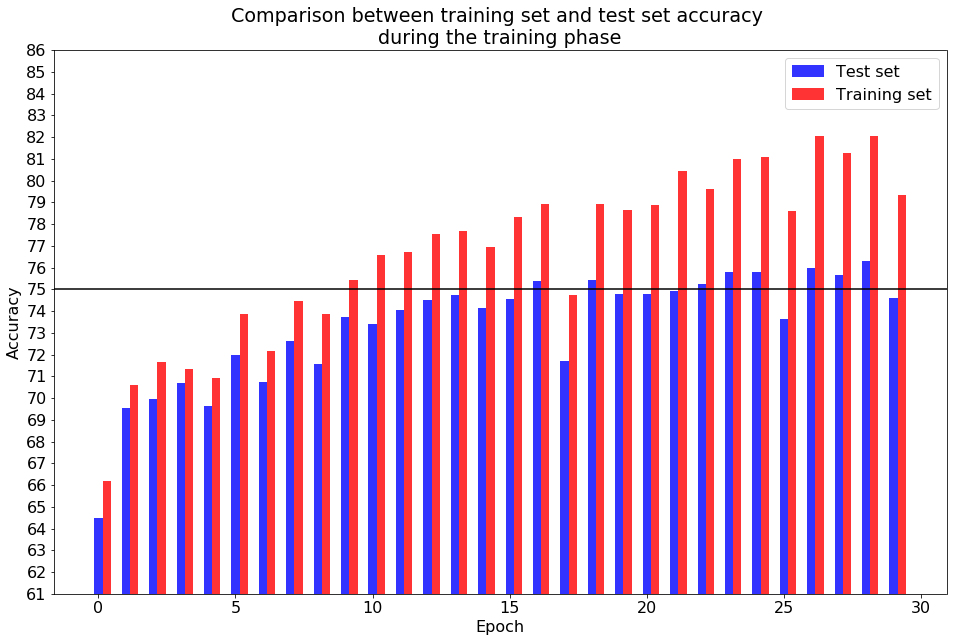

In [37]:
from matplotlib.pyplot import figure # to plot
import datetime                      # to include date in log file name
# import warnings
# warnings.filterwarnings('ignore')
#save it
want_log = True
path_to_save = "./log/" + datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")

# data to plot
n_groups = nb_epoch 
accuracy_toplot = accuracy.numpy()

tests_accuracy = accuracy_toplot[:,0]
train_accuracy = accuracy_toplot[:,1]

#
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (16 ,10)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, tests_accuracy, bar_width,
                 alpha=opacity,
                 color='blue',
                 label='Test set')
 
rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Training set')

eps = 3 
top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


plt.ylim(bot, top)     # set the ylim to bottom, top
plt.axhline(y=75,color="black")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison between training set and test set accuracy \nduring the training phase')
xjump = 5
plt.xticks( np.arange(0, n_groups+1, step=xjump) , range(0,n_groups+2,xjump) )
plt.yticks( range(bot,top+1,1) )
plt.legend()

# plt.tight_layout()
if want_log :
    plt.savefig(path_to_save + ".png")
    with open(path_to_save + ".txt",'w+') as f:
        nb_params, depth = number_of_params(cudanet)
        line = "{name} : number of parameters = {n}, deptp = {d}. , lr = {lr}, batch size = {bs}".format(name = cudanet.__doc__, n = nb_params, d=depth, lr=lr, bs = batch_size)
        f.write(line)
plt.show()

# Misc

#### print some test sample that the net misclassifies

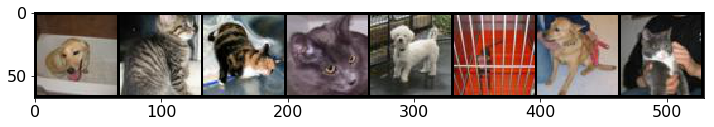

Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure
this should be          :   1   , 0   , 0   , 0   , 1   , 1   , 1   , 0   
net associated prob     :   0.25, 0.82, 1.00, 0.79, 0.30, 0.13, 0.48, 0.97


In [92]:
batch_size = 8
valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

nb_of_error = torch.tensor([8])
j = torch.tensor([0])
errorimages  = torch.empty(8,3,64,64)
errorlabels  = torch.empty(8)
erroroutputs = torch.empty(8)
for images, labels in valid_loader :
    images, labels = images.to(device), labels.to(device)
    outputs = cuda_test_net(images).squeeze()
    # if using BCE
    # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
    # if using multi class cross entropy
    _, predicted = torch.max(outputs.data, 1)
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j] = outputs[i,1].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break
        
if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )
    
    print( "Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure")
    print( "this should be          : " , ",".join( " %-4d" % nb.item() for nb in errorlabels ) ) 
    print( "net associated prob     : " , ",".join( "%5.2f" % nb.item() for nb in erroroutputs ) ) 

Does stuff

In [310]:
for i,(name,layer) in enumerate(cudanet.named_parameters(),1) :
    print(i , "name : " , name , " : \n" , layer.size() )

1 name :  conv.0.weight  : 
 torch.Size([16, 3, 5, 5])
2 name :  conv.0.bias  : 
 torch.Size([16])
3 name :  conv.3.weight  : 
 torch.Size([32, 16, 5, 5])
4 name :  conv.3.bias  : 
 torch.Size([32])
5 name :  conv.6.weight  : 
 torch.Size([64, 32, 5, 5])
6 name :  conv.6.bias  : 
 torch.Size([64])
7 name :  conv.9.weight  : 
 torch.Size([128, 64, 5, 5])
8 name :  conv.9.bias  : 
 torch.Size([128])
9 name :  conv.11.weight  : 
 torch.Size([128, 128, 5, 5])
10 name :  conv.11.bias  : 
 torch.Size([128])
11 name :  conv.13.weight  : 
 torch.Size([256, 128, 3, 3])
12 name :  conv.13.bias  : 
 torch.Size([256])
13 name :  fct.weight  : 
 torch.Size([2, 16384])
14 name :  fct.bias  : 
 torch.Size([2])


#### Vizualize conv weigths

In [218]:
del net

In [153]:
net = Classifier5()
net.load_state_dict(cudanet.state_dict(),strict=False)

### Visualize feature maps

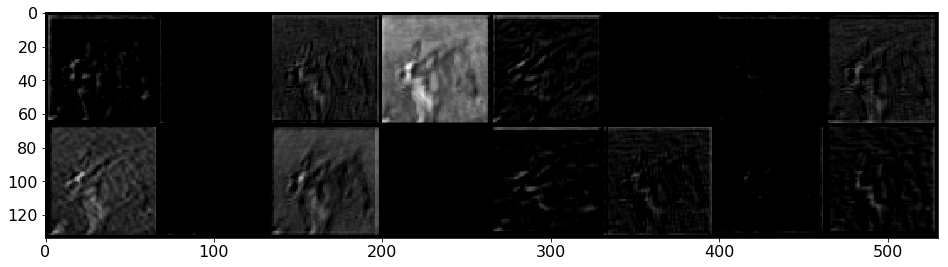

tensor(255.) tensor(0.)


In [163]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

layer = "1" # display all feature map of sample_image from layer
with torch.no_grad() :
    #print( net._modules )
    net.conv._modules[layer].register_forward_hook(get_activation(layer))
    output = net(sample_image.unsqueeze(0))

    act = activation[layer].squeeze().unsqueeze(1)
    # print(act.size())
    act = act - act.min()
    act = act / act.max() * 255
        
imshow(torchvision.utils.make_grid(act ))
print(act.max(),act.min())

### vizualize kernels, not useful

tensor(255.) tensor(0.)


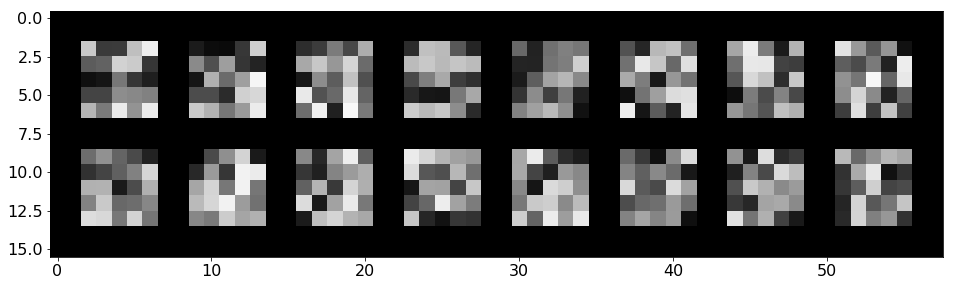

tensor(255.) tensor(0.)


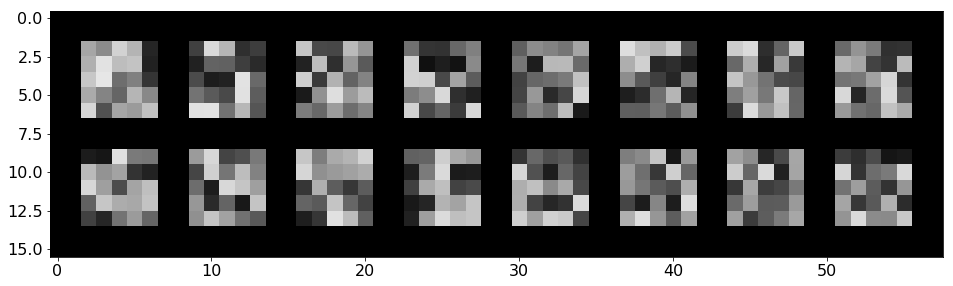

tensor(255.) tensor(0.)


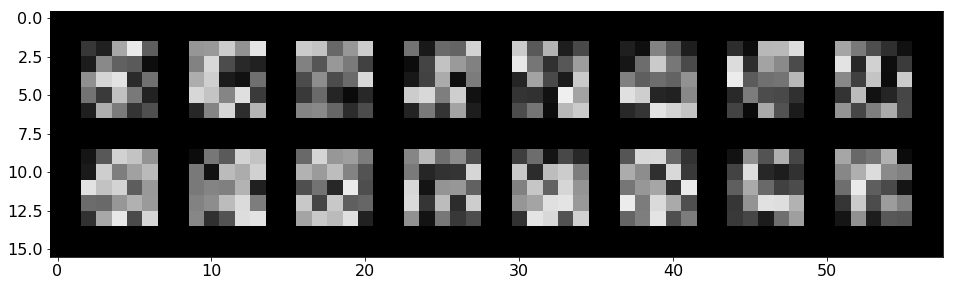

tensor(255.) tensor(0.)


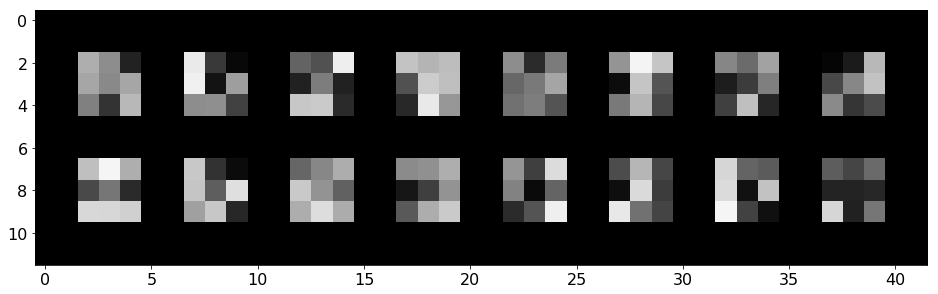

tensor(255.) tensor(0.)


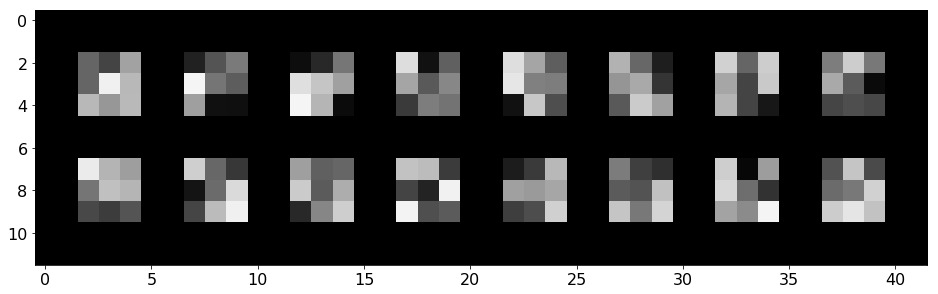

tensor(255.) tensor(0.)


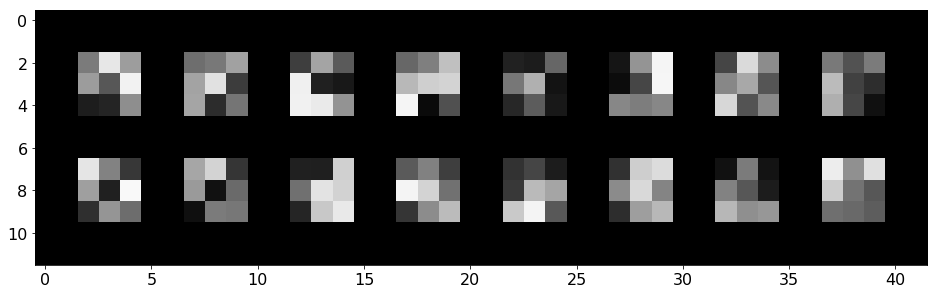

tensor(255.) tensor(0.)


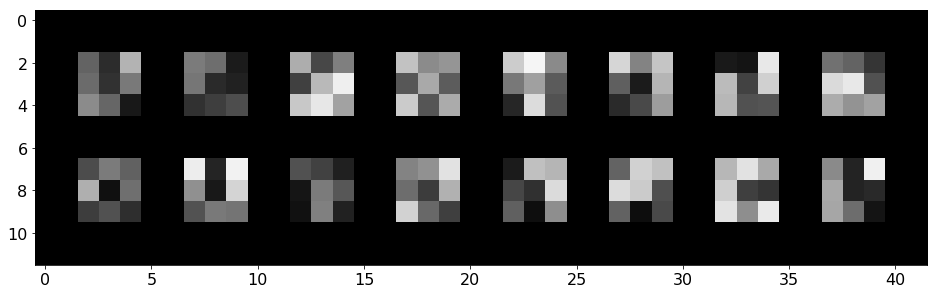

In [157]:
for i,(name, kernels) in enumerate(net.state_dict().items()) :
    if not (name.startswith("conv") and name.endswith("weight") ):
        continue 
    kernels = kernels.detach().view(-1,1,kernels.size()[-1],kernels.size()[-1])
    kernels = kernels - kernels.min()
    kernels = 255 * kernels / kernels.max() 
    size = min(kernels.size()[0],16)
    print( kernels.max() , kernels.min() )
    # print(kernels.size())
    imshow(torchvision.utils.make_grid(kernels[0:size,:,:,:]))

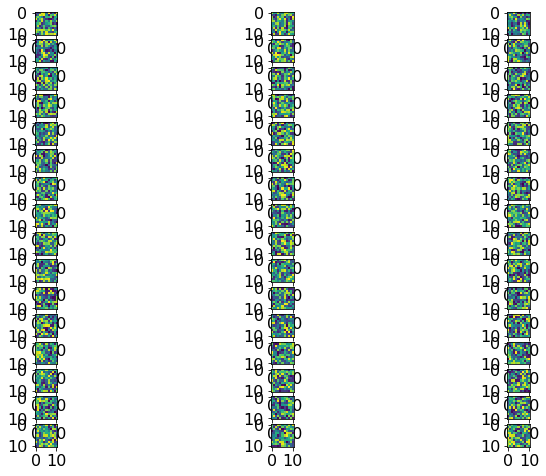

In [178]:

for i,(name, kernels) in enumerate(net.named_parameters()) :
    if i == 0 :
        kernels = kernels.detach()
        fig, axarr = plt.subplots(kernels.size(0),kernels.size(1))
        for idx in range(kernels.size(0)):
            for j in range(kernels.size(1)):
                axarr[idx,j].imshow(kernels[idx,j,:,:].squeeze())

conv.0.weight  =  [[ -7  -9  -5  11  10  -4  12 -11  -4 -11  10]
 [-11  -2  11   9  11   0 -11   5   3  10  -2]
 [  4   6   2  -1 -11   3   3   7 -12   0   2]
 [ 11  -3   5  10  -4  -9 -13 -12  -8   2  -8]
 [-11   2  -3  10  -8   3  -3   8  -1  -4   8]
 [  0   4   7 -10  -6   0   3   6 -11  -7 -13]
 [ -4   8 -11  -5   5  -4  -6   3   6   7  -4]
 [ -9   1  -4 -10   4  -9   4  -5 -11  -5 -10]
 [  9   7   9   9   8   4   8   1  11  -2  -7]
 [  8   4  -2   8  -5  10  -3  -6  -9   2   5]
 [  0 -10  -2   7   0  11   8   9   8  11  -5]]


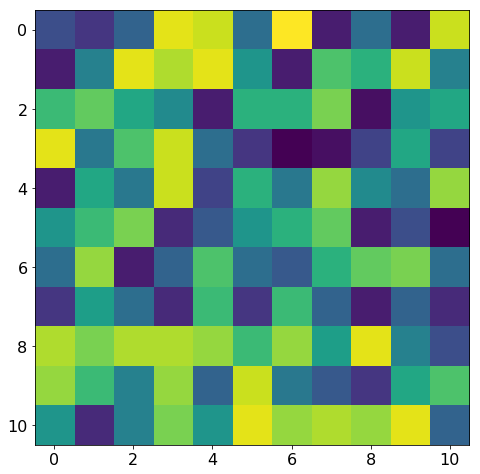

In [173]:
for layer, weight in cudanet.state_dict().items() :
    if layer.startswith("conv") and layer.endswith("weight") :
        tmp_weight = copy.deepcopy(weight.data).cpu().numpy() * 255
        tmp_weight = tmp_weight.astype(int)
        print(layer , " = " , tmp_weight[0,0,...])
        plt.imshow(tmp_weight[0,0,...])
        break
        

# Submit

In [99]:
total_nb_of_sample = 4999 # total number of sample per class, this shouldn't be hardcoded

class nonlabeledDataSet(torch.utils.data.Dataset):

    def __init__(self , nb_of_sample, root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()  
        self.root_dir = root_dir
        self.nb_of_sample = nb_of_sample
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor   = torch.empty(size,3,64,64,dtype=torch.float)
        
        for i in range(self.nb_of_sample) :
            j = i + 1
            img_path = self.root_dir +  "{index}.jpg".format(index=j)
            img = Image.open( img_path ).convert('RGB')
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            image = image
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        return self.nb_of_sample

    def __getitem__(self, idx):
        return self.data_tensor[idx]


In [100]:
file_name = "./data_catdogs/sample_submission.csv"
file = open(file_name, 'r')
# print(repr(file.read() ) )

In [74]:
loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
# loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5d()
# loading_path = "./save/classifier5wsm_nocrop_51to100/dev1num3model_for_epoch50.pth" # Classifier5()
cudanet_tocpu = Classifier1()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet2 = copy.deepcopy( cudanet_tocpu ).to(device)

In [75]:
criterion = nn.CrossEntropyLoss()
batch_size = 16*64
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( cudanet2 , train_loader, criterion )
print(a.item(), "loss : " , b.item())
a,b = measure_single_accuracy_and_loss( cudanet2 , valid_loader, criterion )
print(a.item(), "loss : " , b.item())

80.22667694091797 loss :  0.49161943793296814
77.78889465332031 loss :  0.5254817605018616


In [111]:
# testset_dir = '/content/drive/My Drive/data_catdogs/testset/'
testset_dir  = "./data_catdogs/testset/"
batch_size=16*64
# test_dataset = torchvision.datasets.ImageFolder(root=testset_dir,transform=data_transforms["veryaugmented"]) 
# test_dataset = torchvision.datasets.ImageFolder(root=testset_dir,transform=data_transforms["normal"])
# test_loader  = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=num_workers)
test_dataset = nonlabeledDataSet(4999,testset_dir+"test/")
test_loader  = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=num_workers)

def class_from_index(ind):
    return train_dataset_norm.classes[ind]

remember_prediction = torch.empty(batch_size)
with open('submission3.csv', mode='w') as submission:
    submission.write('id,label\n')
    i = 1
    for query in test_loader:
        img = query
        with torch.no_grad():
            img          = img.to(device)
            outputs      = cudanet2(img).squeeze()
            # _, predicted = torch.max(outputs.data, 1)
            outputs = cudanet1(img)
            _, predicted1 = torch.max(outputs.data, 1)
            outputs = cudanet2(img)
            _, predicted2 = torch.max(outputs.data, 1)
            outputs = cudanet3(img)
            _, predicted3 = torch.max(outputs.data, 1)
            predicted , _ = torch.mode(torch.cat((predicted1.unsqueeze(1),predicted2.unsqueeze(1),predicted3.unsqueeze(1)),-1).squeeze(),-1)
    
            if i == 1 :
                remember_prediction = copy.deepcopy(predicted).cpu()
            for j in range(predicted.shape[0]) :
                idx    = predicted[j]
                label  = class_from_index(idx)
                submission.write('{},{}\n'.format(i,label) )
                i = i + 1

In [112]:
good_test_answers = torch.zeros(100,dtype=torch.long)
dog_idx = [2,4,6,7,8,14,16,17,19,20,22,24,26,29,31,32,39,41,43,45,53,58,61,
           63,69,70,71,74,75,76,77,82,83,84,86,87,89,93,94,97,98,99]
for i in dog_idx :
    good_test_answers[i-1] = 1
    
count = 0
prediction = remember_prediction[:100]
for i in range(100):
    if prediction[i] == good_test_answers[i] :
        count = count + 1
print(count)
print(good_test_answers)
print(prediction)
# for i in range(len(dog_idx)):
    

83
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1])


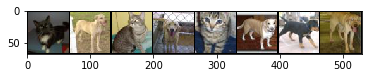

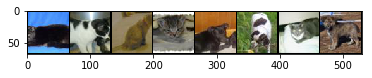

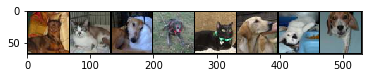

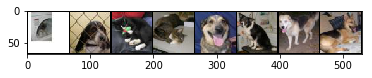

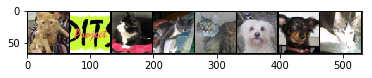

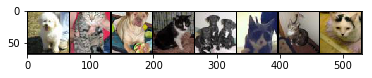

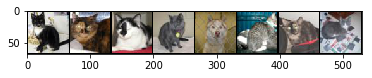

In [113]:
test_pict_loader  = DataLoader(test_dataset, batch_size=8,shuffle=False, num_workers=num_workers)
for i,(img) in enumerate(test_pict_loader):
    imshow(torchvision.utils.make_grid(img))
    if i > 5 :
        break

In [ ]:
# 1  , 2  , 3  , 4  , 5  , 6  , 7  , 8  , 9  , 10
# Cat, Dog, Cat, Dog, Cat, Dog, Dog, Dog, Cat, Cat

In [74]:
a = torch.ones(3)
b = torch.zeros(2)
c = torch.cat((a,b) )
print(c)
for i in list(c):
    print(i.item())

tensor([1., 1., 1., 0., 0.])


TypeError: only integer tensors of a single element can be converted to an index

### Save and load models

In [164]:
# save current state only
saving_path = "./save/dev1num3model.pth"
cudanet_tocpu = cudanet.cpu()
tmp_state_dict = cudanet_tocpu.state_dict()
torch.save( tmp_state_dict , saving_path )
_ = cudanet.to(device)

In [106]:
# load one state

# loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
# loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5()
# loading_path = "./save/classifier1b_1to30\dev1num3model_for_epoch30.pth" # Classifier1b()
# loading_path = "./save/classifier1_150to200/dev1num3model_for_epoch50.pth" # Classifier1()

# loading_path = "./save/dev1num3model.pth"
# cudanet_tocpu = Classifier1()
# cudanet_tocpu = Classifier5()
# cudanet_tocpu = Classifier1b()
# cudanet_tocpu = Classifier1()
# cudanet_tocpu.load_state_dict(torch.load(loading_path))
# cudanet4 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
cudanet_tocpu = Classifier1()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet1 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5()
cudanet_tocpu = Classifier5d()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet2 = copy.deepcopy( cudanet_tocpu ).to(device)

# cudanet3 = copy.deepcopy(cudanet)
# loading_path = "./save/classifier1b_1to30\dev1num3model_for_epoch30.pth" # Classifier1b()
# cudanet_tocpu = Classifier1b()
# cudanet_tocpu.load_state_dict(torch.load(loading_path))
# cudanet3 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/classifier5wsm_nocrop_100to151/dev1num3model_for_epoch50.pth" # Classifier5()
cudanet_tocpu = Classifier5()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet3 = copy.deepcopy( cudanet_tocpu ).to(device)

#### Save the state_dict of the model for each epoch on a local directory

In [217]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)
    # print( saving_path )

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num3model_for_epoch{j}.pth" for j from ... to ...

In [107]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx   = nb_epoch

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    # print( path )
else : 
    cudanet = Classifier6( )
    cudanet.load_state_dict(tmp_dict)
    cudanet.to(device)
    cudanet.eval()                     

### Other stuff  
see some models :  
https://pytorch.org/docs/stable/torchvision/models.html

dense net as in :  
https://pytorch.org/docs/stable/_modules/torchvision/models/densenet.html#densenet121

In [ ]:
# test to import greyscale with transforms.ToTensor()


In [ ]:
# check if there is an image of size 80
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=valid_sampler, num_workers=num_workers)
for i, (images, labels) in enumerate(pict_a_loader) :
    if images.size()[3] == 80 :
        imshow(torchvision.utils.make_grid(images))
        break

In [28]:
with torch.no_grad() :
    A = torch.ones(5,5) + torch.transpose(torch.tensor([[1,2,3,4,5]],dtype=torch.float),1,0)
    xx = torch.ones(3,5,5)
    print(A)
    xx = torch.matmul(A, xx) 
    print( xx )
    xx = xx.view(-1,5*5)
    print(xx)
    

tensor([[2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6.]])
tensor([[[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]]])
tensor([[10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 1

#### Deprecated

In [84]:
total_nb_of_sample = 4999 # total number of sample per class, this shouldn't be hardcoded
class labeledDataSet(torch.utils.data.Dataset):

    def __init__(self, label, idx_min , idx_max , root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()
        dic = {"Cat" : int(1) , "Dog" : int(0)}
        
        if dic.get(label , "not found" ) == "not found" :
            raise ValueError("label must either be Cat or Dog")
            
        if idx_max > total_nb_of_sample or idx_min < 0 :
            raise ValueError("min, max index error")
            
        self.label_name = label
        self.idx_min = idx_min
        self.idx_max = idx_max
        self.label = dic[label]
        self.root_dir = root_dir
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor = torch.empty(size,3,64,64,dtype=torch.float)
        self.target_tensor = torch.ones(size,dtype=torch.long) * self.label
        
        for i,j in enumerate(range( self.idx_min , self.idx_max , 1 ),0) :
            img_path = self.root_dir +  "/{index}.{Label}.jpg".format(index=(j),Label=self.label_name)
            # image = io.imread(img_name)
            # print( i , " : " , io.imread(img_name).shape )
            # img = io.imread(img_name)
            # print( img_path )
            img = Image.open( img_path ).convert('RGB')
            """
            NOTE : There is at least one grey-scale picture of Einstein, manually remove it ?
            the greyscale (1 channel) images have to be converted to 3 channels tensors
            """   
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        # return len(self.name_frame)
        return (self.idx_max - self.idx_min + 1)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.target_tensor[idx]


In [ ]:
# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )
dog_dir = "./data_catdogs/trainset/Dog"
cat_dir = "./data_catdogs/trainset/Cat"

# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )

trainset = torch.utils.data.ConcatDataset( [ trainDogSet , trainCatSet ] )
testsset = torch.utils.data.ConcatDataset( [ testsDogSet , testsCatSet ] )

( "img size = " , img.size() , "label size = " , label.size() )
testing_dataset_size  = testsCatSet.__len__() + testsDogSet.__len__()
training_dataset_size = trainCatSet.__len__() + trainDogSet.__len__()

print( "training dataset size = " , training_dataset_size ) 
print( "testing  dataset size = " , testing_dataset_size ) 
print( trainDogSet.__doc__ ) 
img, label =  trainDogSet.__getitem__(1)
print( "img size = " , img.size() , "label size = " , label.size() )